In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from scipy import stats

In [5]:
data = pd.read_csv('../train.csv')

In [22]:
#My data 40 variables
df = data.loc[:,'CentralAir':]

In [94]:
#types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 40 columns):
CentralAir       1460 non-null object
Electrical       1459 non-null object
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
KitchenQual      1460 non-null object
TotRmsAbvGrd     1460 non-null int64
Functional       1460 non-null object
Fireplaces       1460 non-null int64
FireplaceQu      770 non-null object
GarageType       1379 non-null object
GarageYrBlt      1379 non-null float64
GarageFinish     1379 non-null object
GarageCars       1460 non-null int64
GarageArea       1460 non-null int64
GarageQual       1379 non-null object
GarageCond       1379 non-null ob

In [150]:
#sets are obj variables in my 40
sets = ['CentralAir', 'Electrical', 'KitchenQual', 
             'Functional', 'FireplaceQu','Fireplaces', 'GarageType', 
             'GarageFinish', 'GarageQual', 'GarageQual',
             'PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition']

#testing other values
sets2= ['Fence',
'MiscFeature',
'MiscVal',
'MoSold',
'YrSold',
'SaleType',
'SaleCondition']

#Jaye function to count unique values
for c in df.columns[:]:
    if c in sets2:
        print('\nCOLUMN: "{}"\n=============================='.format(c))
        print(df[c].value_counts(dropna=False).to_string())
        # only include above columns categorical
        continue


COLUMN: "Fence"
NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11

COLUMN: "MiscFeature"
NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1

COLUMN: "MiscVal"
0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1

COLUMN: "MoSold"
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52

COLUMN: "YrSold"
2009    338
2007    329
2006    314
2008    304
2010    175

COLUMN: "SaleType"
WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2

COLUMN: "SaleCondition"
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4


In [60]:
#total missing columns

#df.isnull().any()
df.isna().sum()

CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
PoolQC           1453
Fence            1179
MiscFeature      1406
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
dtype: int64

In [98]:
#percentage of missing per column
(df.count() / 1460) *100

CentralAir       100.000000
Electrical        99.931507
1stFlrSF         100.000000
2ndFlrSF         100.000000
LowQualFinSF     100.000000
GrLivArea        100.000000
BsmtFullBath     100.000000
BsmtHalfBath     100.000000
FullBath         100.000000
HalfBath         100.000000
BedroomAbvGr     100.000000
KitchenAbvGr     100.000000
KitchenQual      100.000000
TotRmsAbvGrd     100.000000
Functional       100.000000
Fireplaces       100.000000
FireplaceQu       52.739726
GarageType        94.452055
GarageYrBlt       94.452055
GarageFinish      94.452055
GarageCars       100.000000
GarageArea       100.000000
GarageQual        94.452055
GarageCond        94.452055
PavedDrive       100.000000
WoodDeckSF       100.000000
OpenPorchSF      100.000000
EnclosedPorch    100.000000
3SsnPorch        100.000000
ScreenPorch      100.000000
PoolArea         100.000000
PoolQC             0.479452
Fence             19.246575
MiscFeature        3.698630
MiscVal          100.000000
MoSold           100

In [132]:
#where there is no full bath above ground, 
a = np.where(df['FullBath'].values == 0)
print(df.loc[a])

#misc features
# b = np.where(df['MiscFeature'].values == 'Shed')
# print(df.loc[b])

     CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
53            Y      SBrkr      1842         0             0       1842   
188           Y      SBrkr      1224         0             0       1224   
375           N      FuseA       904         0             0        904   
597           Y      SBrkr      1402         0             0       1402   
634           Y      SBrkr      1056         0             0       1056   
916           N      FuseA       480         0             0        480   
1163          Y      SBrkr      1258         0             0       1258   
1213          Y      SBrkr       960         0             0        960   
1270          Y      SBrkr      1332       192             0       1524   

      BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  ...  PoolArea  PoolQC  \
53               2             0         0         1  ...         0     NaN   
188              2             0         0         2  ...         0     NaN   
375         

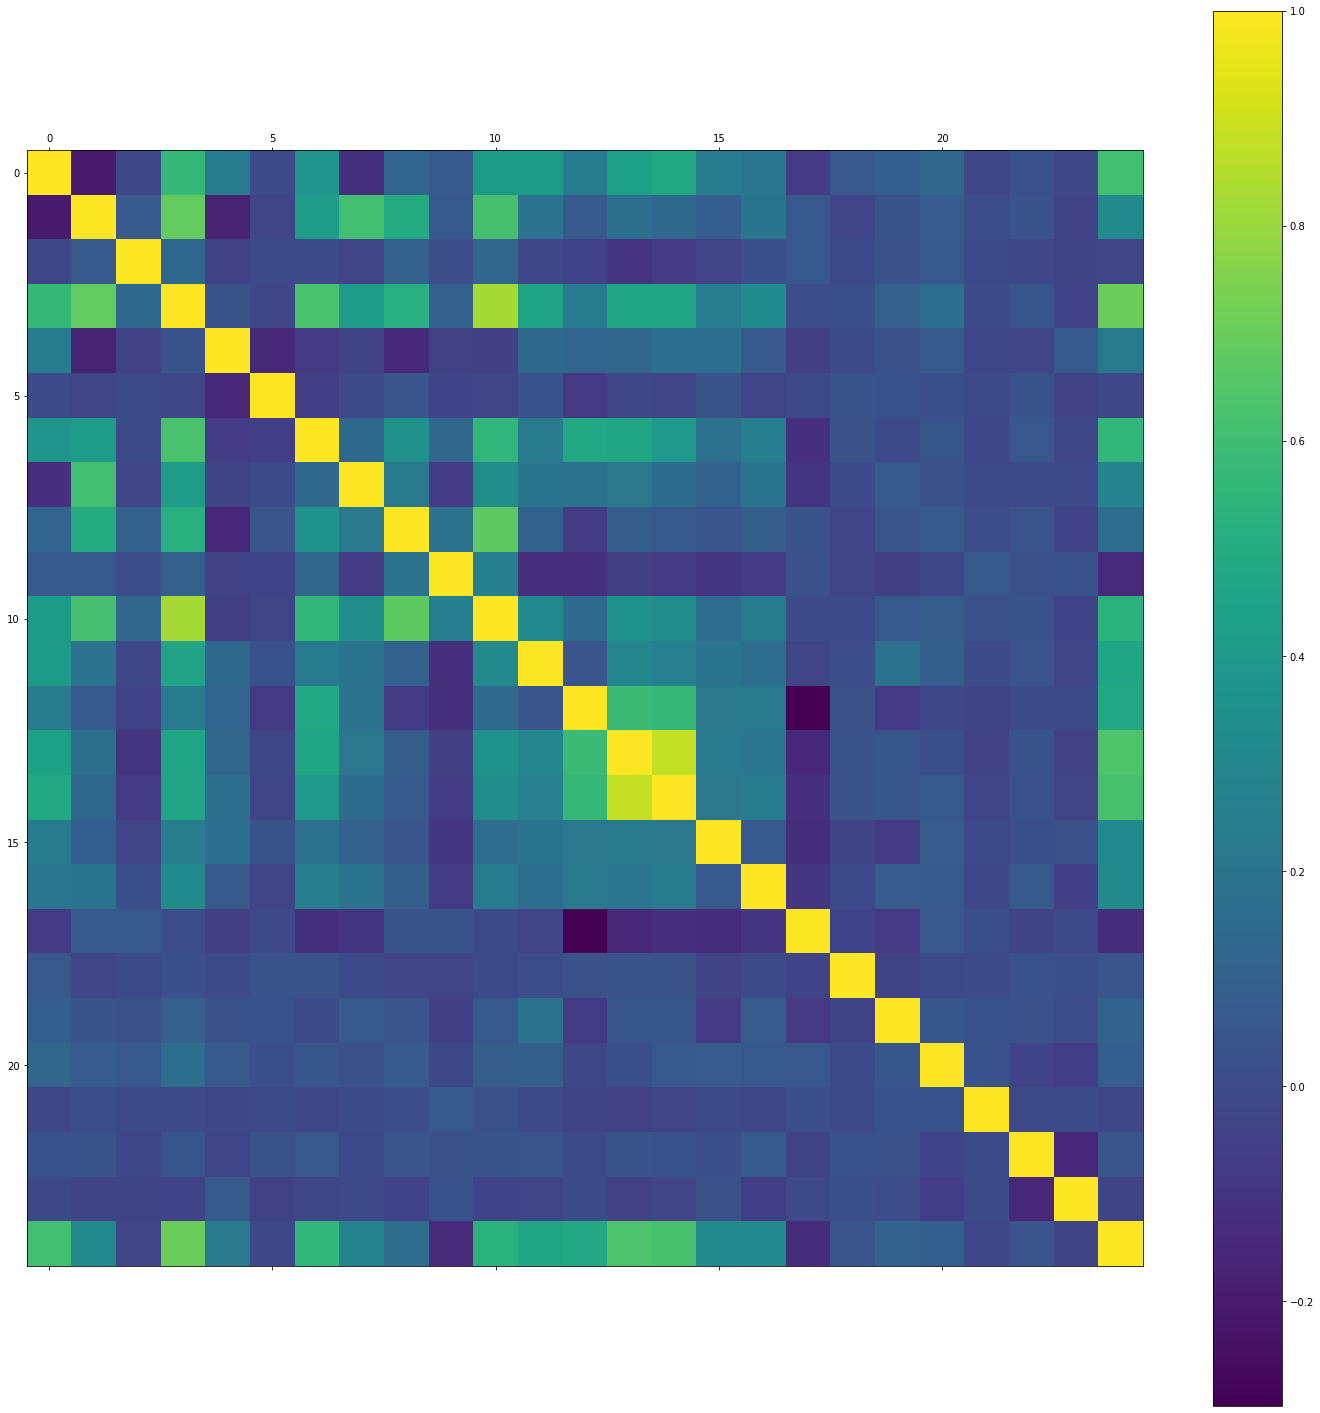

In [44]:
#visual correlation matrix
f = plt.figure(figsize=(25,25))
plt.matshow(df.corr(), fignum=f.number)
cb = plt.colorbar()

In [53]:
#correlation matrix to csv
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so.to_csv('./corr.csv')

C:\Users\conma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [77]:
#alphas = np.linspace(0.1,20.1,20)
#df (house_features) type-dataframe- 
#target (prices) type-series 

def lassoReg (alphas, df, target):

    lasso  = Lasso()
    #alphas = np.linspace(0.1,20.1,20)
    lasso.set_params(normalize=False)
    coefs_lasso  = []

    for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(df, target)  
        coefs_lasso.append(lasso.coef_)

    coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = df.columns)  
    #coefs_lasso.head()
    
    plt.rcParams['figure.figsize'] = (20,20)
    for name in coefs_lasso.columns:
        plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
        
        
    plt.xlabel(r'hyperparameter $\lambda$')
    plt.ylabel(r'slope values')
    plt.legend(loc=1)
#lassoReg(alphas,df2,prices)

In [82]:
#alphas is lambda -linspace or discrete lambda-
#df type-dataframe- 
#target type-series-

def elasticNet (alphas, df, target, rho):

    elasticnet = ElasticNet()
    elasticnet.set_params(normalize=False)
    coefs_model  = []
    #run through many alphas(lambdas)
    for alpha in alphas:
        elasticnet.set_params(alpha=alpha, l1_ratio= rho)
        elasticnet.fit(df, target)  
        coefs_model.append(elasticnet.coef_)

    coefs_model = pd.DataFrame(coefs_model, index = alphas, columns = df.columns)  
    
    #plot all the figures for different lambda
    plt.rcParams['figure.figsize'] = (20,20)
    for name in coefs_model.columns:
        plt.plot(coefs_model.index, coefs_model[name], label=name)
            
    plt.xlabel(r'hyperparameter $\lambda$')
    plt.ylabel(r'slope values')
    plt.legend(loc=1)

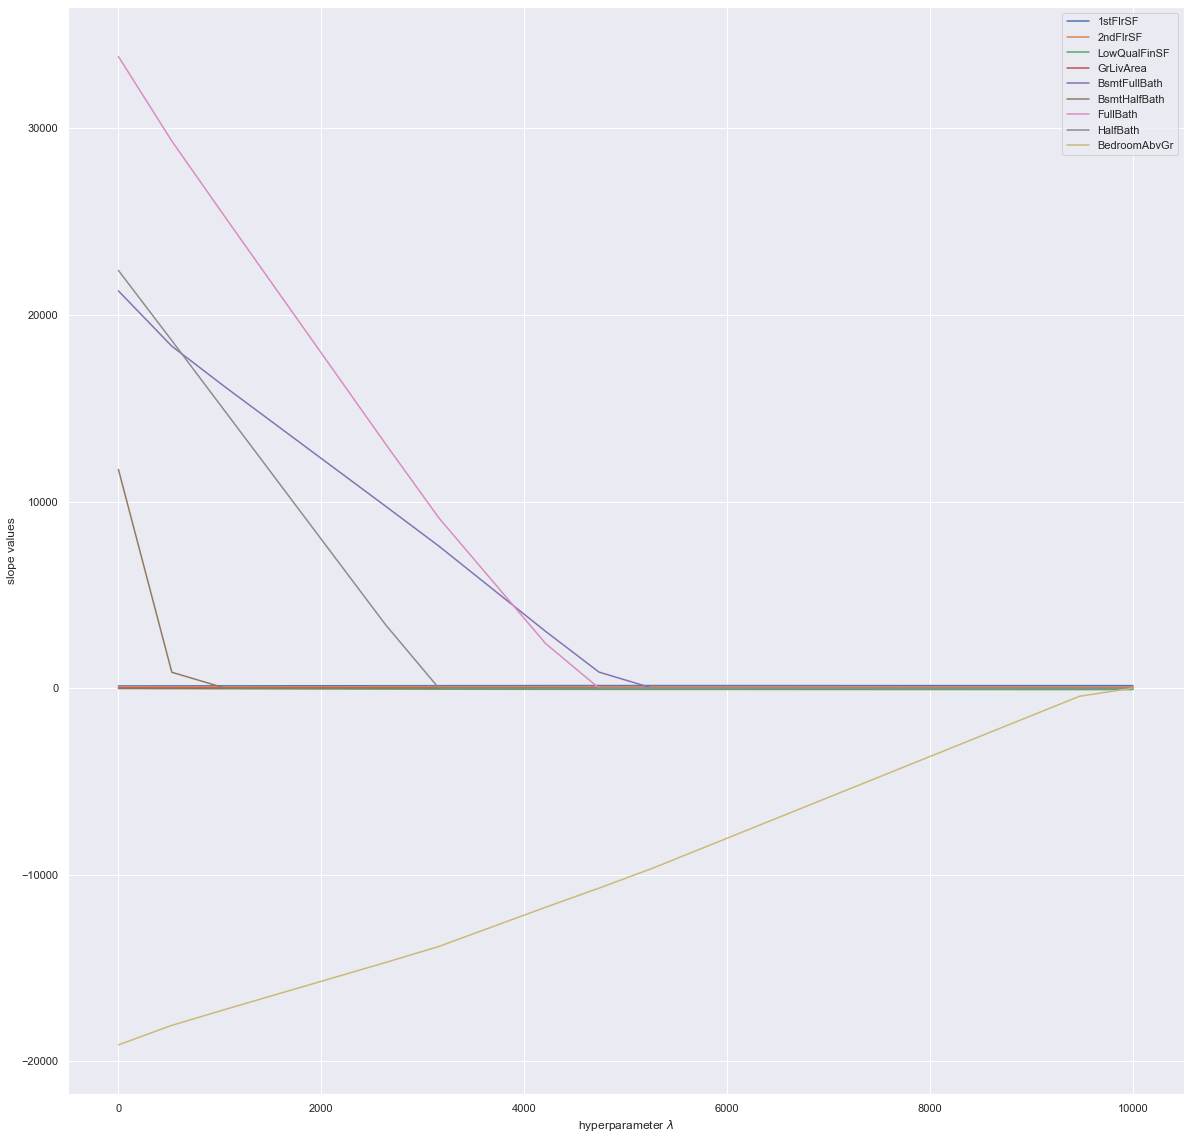

In [193]:
#lambda
alphas = np.linspace(0.1,1e4,20)
#target
prices = pd.Series(df.SalePrice)

#numerical dataframe
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df2 = df.select_dtypes(include=numerics).copy() #81 na in GarageYrBlt
df2.isna().sum() #count nas per col
df2.GarageYrBlt.fillna(0, inplace=True) # replace na with 0 because no data given
#df2 has 25 columns, 10 unique colors for elasticNet

elasticNet(alphas,df2.iloc[:,:9],prices,1) #1 for lasso, 0 for ridge, mixture is elastic net

C:\Users\conma\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


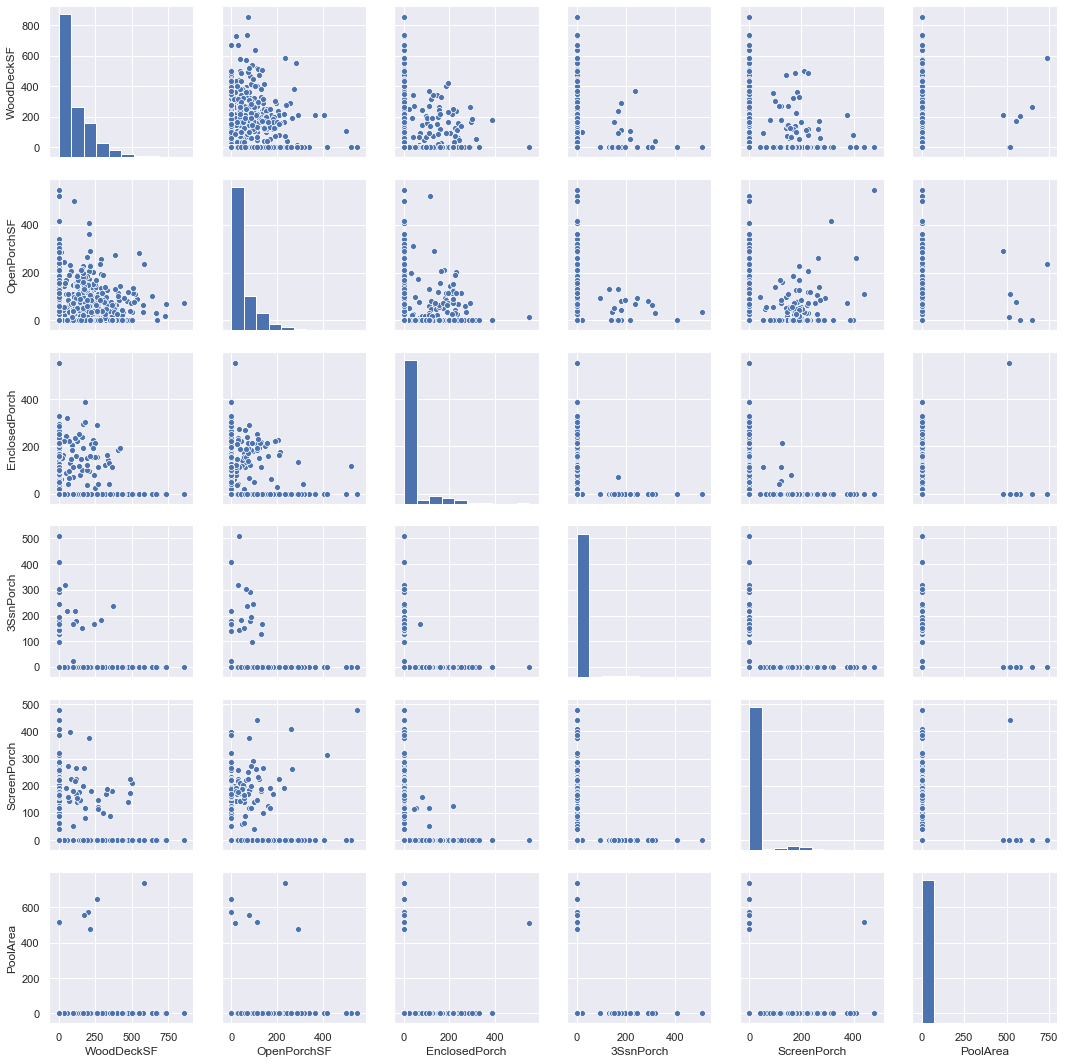

<Figure size 1440x1440 with 0 Axes>

In [113]:
#Jason function for scatterplots
sns.set()
cols = ['WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea']
sns.pairplot(df[cols], size = 2.5)
plt.show();
plt.savefig('pairplot.png',bbox_inches='tight')